In [1]:
!nvidia-smi

Fri Aug 25 13:54:38 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |    633MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   29C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import pickle as pk
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


Load in the CSV files

In [5]:
%%time
modelpath   = "data/models/some-model-path.h5"
trainpath   = "data/sets/UNIF-10N-25T-200E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)

CPU times: user 1.66 s, sys: 48 ms, total: 1.7 s
Wall time: 1.7 s


Make a list of events. Each event is a dataframe

In [6]:
%%time
train = utils.list_of_groups(train_frame, group="event_id")
test  = utils.list_of_groups(test_frame,  group="event_id")
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))

Train is list of 4800 events.
Test is list of 3600 events.
CPU times: user 1.22 s, sys: 36 ms, total: 1.26 s
Wall time: 1.26 s


In [7]:
order = ["phi", "r", "z"]

Train 2571
Number of Hits: 119
Number of Tracks: 13


<IPython.core.display.Javascript object>


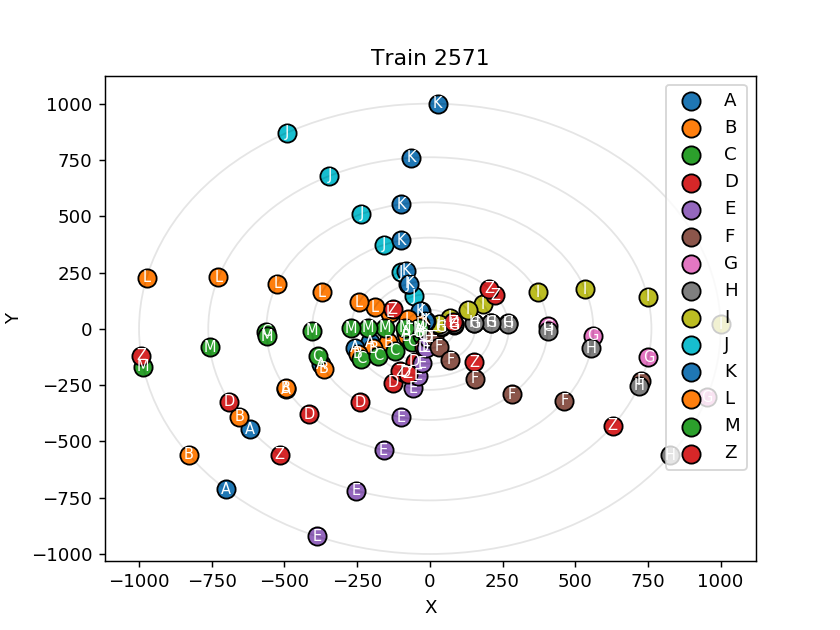

In [8]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [9]:
print(n)
visuals.display(train[n], order)

2571


,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-3.118764,562.0,51.860840,,,1,,,,,,,,,,,,,,,,,,,,,,,,
1,-3.117964,405.0,9.880130,,,,,,,,,,,,,1,,,,,,,,,,,,,,
2,-3.081122,562.0,13.710205,,,,,,,,,,,,,1,,,,,,,,,,,,,,
3,-3.032567,762.0,18.589282,,,,,,,,,,,,,1,,,,,,,,,,,,,,
4,-3.021852,1000.0,11.188954,,,,,,,,,,,,,,,,,,,,,,,,,,1,
5,-2.973493,1000.0,24.395383,,,,,,,,,,,,,1,,,,,,,,,,,,,,
6,-2.967887,39.0,-6.755456,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.938778,85.0,-14.723429,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.861732,213.0,-36.895181,1,,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.834614,405.0,37.373025,,,1,,,,,,,,,,,,,,,,,,,,,,,,


In [10]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [11]:
model = Sequential()
model.add(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax", input_shape=input_shape))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 235, 27)           108       
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________


In [12]:
%%time
# 32 + 32 + 64 + 64
epochs     = 4
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,)]))

Epoch 1/4
48/48 [==============================] - 43s - loss: 4.9738 - acc: 0.5326 - val_loss: 3.3076 - val_acc: 0.6523
Epoch 2/4
48/48 [==============================] - 36s - loss: 3.6061 - acc: 0.5618 - val_loss: 3.0414 - val_acc: 0.6488
Epoch 3/4
48/48 [==============================] - 38s - loss: 3.1836 - acc: 0.5666 - val_loss: 3.0394 - val_acc: 0.6568
Epoch 4/4
48/48 [==============================] - 38s - loss: 3.0331 - acc: 0.5677 - val_loss: 3.0108 - val_acc: 0.6556
CPU times: user 3min 13s, sys: 4.63 s, total: 3min 18s
Wall time: 3min 13s


In [15]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 12.706809937062078%
Percent of tracks assigned correctly: 0.0%
Percent of events with the correct number of tracks: 10.777777777777779%
CPU times: user 1min 11s, sys: 28 ms, total: 1min 11s
Wall time: 1min 11s


In [ ]:
n = 6
d = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy")
d = visuals.Plot2D(test[n], order).plot(mode="xy")

In [ ]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")